Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 78476424.90it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 15092909.77it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 26487113.93it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1407189.30it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/5], Loss: 0.1473
Epoch [2/5], Loss: 0.0444
Epoch [3/5], Loss: 0.0306
Epoch [4/5], Loss: 0.0230
Epoch [5/5], Loss: 0.0185
Test Accuracy: 98.95%


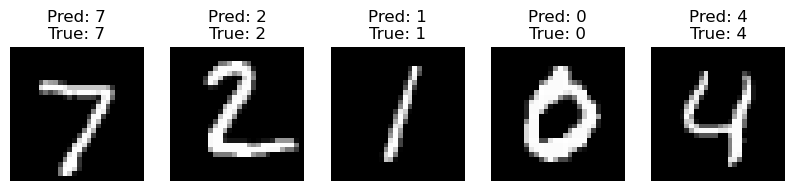


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean 0 and std deviation 1
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(128, 10)  # Output layer for 10 classes (digits 0-9)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Display some predictions
def display_prediction(images, labels, predictions):
    fig, axes = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(5):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(f"Pred: {predictions[i]}\nTrue: {labels[i]}")
        axes[i].axis('off')
    plt.show()

# Get some test data and predictions for visualization
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images)
_, predictions = torch.max(outputs, 1)
display_prediction(images.numpy(), labels.numpy(), predictions.numpy())

# Precision statistics
from sklearn.metrics import classification_report
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))
